## Условия задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 1. Знакомство с данными.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
# зачитаем данные в df, организуем все df в один словарь, а описания данных в другой словарь с теми же ключами
data = {}
data_description = {
    'arc'      : 'данные об электродах',
    'bulk'     : 'данные о подаче сыпучих материалов (объём)', 
    'bulk_time': 'данные о подаче сыпучих материалов (время)',
    'gas'      : 'данные о продувке сплава газом',
    'temp'     : 'результаты измерения температуры',
    'wire'     : 'данные о проволочных материалах (объём)',
    'wire_time': 'данные о проволочных материалах (время)'
}


for data_keys in data_description:
    data[data_keys] = pd.read_csv(f'/datasets/final_steel/data_{data_keys}.csv')

In [4]:
# посмотрим на данные
for df_name in data:
    print(f'****** {df_name} : {data_description[df_name]} ***********')
    print(data[df_name].info())
    display(data[df_name].head(3))

****** arc : данные об электродах ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805

****** bulk : данные о подаче сыпучих материалов (объём) ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0

****** bulk_time : данные о подаче сыпучих материалов (время) ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40

****** gas : данные о продувке сплава газом ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793

****** temp : результаты измерения температуры ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0

****** wire : данные о проволочных материалах (объём) ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN

****** wire_time : данные о проволочных материалах (время) ***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8  \
0    1  2019-05-03 11:11:41    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

  Wire 9  
0    NaN  
1    NaN  
2    NaN

## 1. Выводы после ознакомления с данными.
- Предоставлены данные о 14876 сеансах нагрева, для каждого сеанса - время включения, время выключения, средняя потребленная мощность.
- Предоставлены данные 15907 операциях измерения температуры, но данные об измеренной температуре есть только для 13006 операций, пропущено почти 3000 значений температуры (при этом время замера есть). 
- Сразу бросается в глаза большое кол-во пропусков в данных о подаче сыпучих материалов и проволочных материалов. Однако даже беглый взгляд на данные позволяет предположить, что речь идет не о реальных пропусках, а об особенностях структуры данных. В определенные моменты времени в металл добавляются те или иные вещества (легирующие присадки) либо в виде сыпучих материалов, либо в виде проволоки. В заданный момент времени производится подача только определенных материалов, что обусловлено текущим составом расплава и целевым составом стали. Соответственно, в данных об операциях подачи сыпучих материалов и проволочных материалов должны быть пропуски для всех тех добавок, которые не использовались в данной операции. Таким образом, предоставлены данные о 3129 операциях подачи сыпучих материалов и о 3081 операции подачи проволоки.
- Предоставлены данные о 3239 операции продувки газом. Бросается в глаза, что для операций продувки газом нет данных о времени операции. Исходя из предоставленного нам описания процесса, обдувка производится не постоянно, а в моменты добавления присадок. С этим предстоит разобраться.
- Судя по кол-ву операций легирования и обдува, нам предоставлены данные о примерно 3200 партиях металла (уникальных key). Соответственно, каждую партию несколько раз нагревают и несколько раз измеряют температуру. С этим также предстоит разобраться.
- Все поля datetime в данных зачитались как object. Их необходимо преобразовать.

## 2. Исследовательский анализ данных.

#### 2.1. Преобразуем datetime данные типа object в тип datetime.

In [5]:
# так как все столбцы типа object содержат только данные типа datetime, 
# для преобразования просто выберем object столбцы и преобразуем их в datetime
for df_name in data:
    object_columns = data[df_name].columns[data[df_name].dtypes == 'object']
    for col in object_columns:
        data[df_name][col] = pd.to_datetime(data[df_name][col])

#### 2.2. Структура данных.

На этапе ознакомления с данными возникло предположение о том, что в таблицах bulk, bulk_time, wire, wire_time и gas каждая запись соответствует какой-то конкретной партии металла (уникальному key) Убедимся в том, что все операции легирования и обдува интертным газом в конкретной партии металла (уникальный key) представлены всего только одной строкой в этих таблицах.

In [6]:
for df_name in ['bulk', 'bulk_time', 'wire', 'wire_time', 'gas']: 
    print(f'Кол-во записей для каждого уникального key в таблице {df_name}')
    print(data[df_name]['key'].value_counts())
    print()

Кол-во записей для каждого уникального key в таблице bulk
2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Кол-во записей для каждого уникального key в таблице bulk_time
2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Кол-во записей для каждого уникального key в таблице wire
2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

Кол-во записей для каждого уникального key в таблице wire_time
2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

Кол-во записей для каждого уникального key в таблице gas
2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049 

Итак, понятно, что каждая партия металла во время обработки подвергается нескольким операциям нагрева, нескольким измерениям температуры и нескольким операциям легирования. Исходя из знания физики, понятно, что на температуру расплава могут влиять только следующие факторы:
- Получение тепла. Получаемое расплавом тепло пропорционально длительности нагрева и активной мощности нагрева, по физическому определению мощности, фактором влияния на температуру являются не два этих признака по отдельности, а их произведение.
- Изменение массы. Каждый раз при добавлении присадок происходит смешение основной нагретой массы металла и небольшого кол-ва ненагретого вещества присадок. Насколько мне известно, легирование не является химической реакцией, то есть не сопровождается выделением или поглощением тепла. Даже если это не так на 100%, исходя из полученных нами данных, понятно, что мы вынуждены сделать именно такое предположение, поскольку нам не предоставлены данные о химическом составе присадок, при этом некоторые присадки добавляются очень редко, если бы надо было учитывать химическую реакцию с выделением/поглощением тепла, требовалось бы гораздо больше данных об изменениях температуры из-за химической реакции с участием конкретных присадок. Соответственно, мы можем считать, что изменение температуры при операции добавления присадок происходит только за счет смешения нагретого металла и ненагретых присадок. Соответственно, нам не надо учитывать какая именно присадка добавлена, достаточно только общее кол-во, момент времени и состояние присадки (wire/bulk).
- Рассеяние тепла. Тепло рассеивается со временем - горячие предметы со временем остывают, их температура приходит в равновесие с температурой окружающей среды. Соответственно, на температуру металла должно влиять время. Процесс остывания можно ускорить, например, обдувая горячий металл более холодным газом. Соответственно, на температуру должны влиять и параметры обдува. Остался неясным вопрос, когда именно производится обдув расплава.

Сформированное представление о структуре предоставленных данных хотелось бы визуализировать, чтобы убедиться в правильности этого представления и лучше представить характеристики данных. Для этого создадим функцию, выводящую все операции над конкретной партией металла на один временной график.

In [7]:
def supplement_operations(df, key):
    supplement_times = df[df['key'] == key]
    if len(supplement_times) == 1:
        supplement_times = supplement_times.drop(columns='key').iloc[0,:].dropna().drop_duplicates()
    else:
        supplement_times = pd.Series(dtype='datetime64[ns]')
    return supplement_times  

def show_process(key):
    # для заданной партии металл
    #  извлечем последовательность времен измерения температуры
    temp_times = data['temp'][data['temp']['key'] == key]['Время замера']
    # и соответствующую последовательность величины измеренной температуры
    temp_values = data['temp'][data['temp']['key'] == key]['Температура']
    # у нас есть пропуски в измерениях температуры, но для выводы временных отметок, заполним пропуски 0
    temp_values = temp_values.fillna(0)
    # извлечем последовательность времени старта нагрева
    start_times = data['arc'][data['arc']['key'] == key]['Начало нагрева дугой']
    # извлечем последовательность времени финиша нагрева
    finish_times = data['arc'][data['arc']['key'] == key]['Конец нагрева дугой']
    
    # теперь извлечем последовательность времен добавки присадок из проволоки и сыпучих материалов
    # используем известный нам факт, что в таблице добавки присадок для каждой партии есть только одна запись
    wire_times = supplement_operations(data['wire_time'], key)
    bulk_times = supplement_operations(data['bulk_time'], key)
    
    # определим точку отсчета времени (самое раняя операция из всех у нас имеющихся)
    process_start = min([temp_times.min(), start_times.min()])
    
    # теперь все временные точки преобразуем в длительность в секундах с момента process_start
    temp_times = (temp_times - process_start).dt.seconds
    start_times = (start_times - process_start).dt.seconds
    finish_times = (finish_times - process_start).dt.seconds
    wire_times = (wire_times - process_start).dt.seconds
    bulk_times = (bulk_times - process_start).dt.seconds
    
    # нарисуем график измеренной температуры во времени
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(temp_times, temp_values, marker='o')
    
    # нарисуем периоды нагрева
    for i in start_times.index:
        ax.axvspan(start_times[i], finish_times[i], color='red', alpha=0.2)
    
    # нарисуем операции добавления присадок
    for time in wire_times:
        ax.axvline(time, color='green')
    for time in bulk_times:
        ax.axvline(time, color='lime')
    plt.grid()
    plt.xlim(left=0)
    plt.title(f'Партия {key}, синяя кривая -измерение температуры, зеленые -wire присадки, лайм -bulk присадки, красные области -нагрев')
    plt.xlabel('Время в секундах с момента первой операции с партией металла')
    plt.ylabel('Температура')
    plt.show()

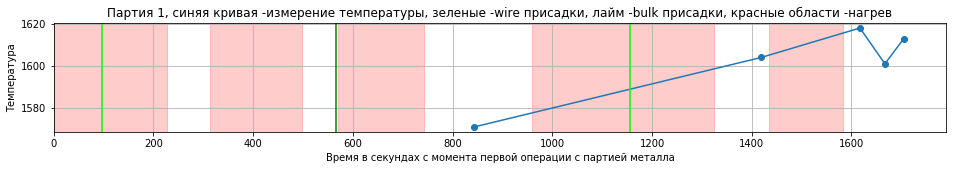

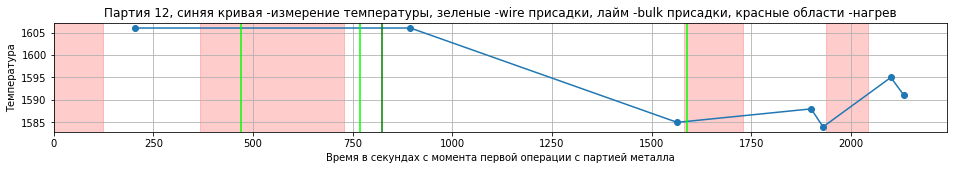

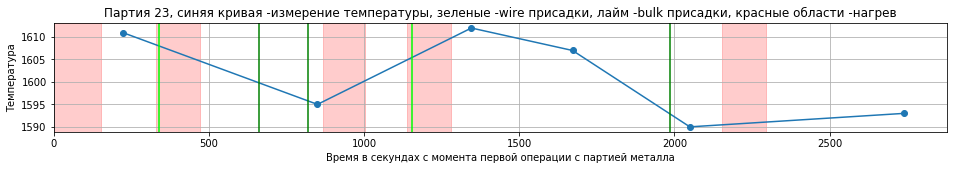

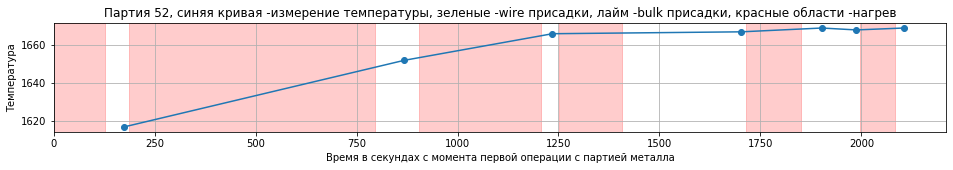

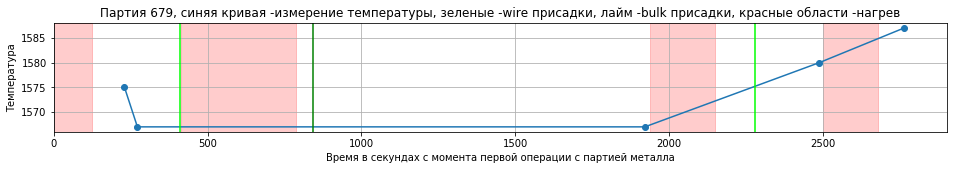

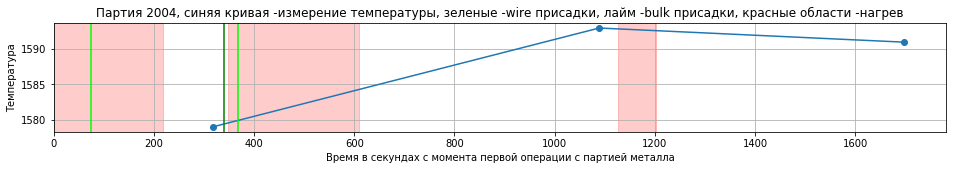

In [8]:
# изобразим временную диаграмму обработки партии металла для нескольких случайно выбранных партий
for key in [1, 12, 23, 52, 679, 2004]:
    show_process(key)

####  Выводы после визуализации процессов обработки партии металла:
- Подтверждается тезис, что нагрев вносит основной вклад в повышение температуры.
- Подтверждается тезис, что остывание металла со временем вносит существенный вклад в снижение температуры - на графиках есть отрезки измерения температуры без каких-либо операций между ними, температура на этих отрезках снижается.
- Есть несколько примечательных участков, когда температура между измерениями изменяется, но это нельзя объяснить имеющимися у нас данными (партия №1 - в самом конце резкое снижение и такой же резкий подъем температуры, партия №12 - резкое снижение температуры в конце). Это факты могут быть обусловлены двумя причинами:
    - измерение температуры не точно, и наблюдаемые нами аномалии следствие случайной ошибки измерений (мне представляется это объяснение самым вероятным)
    - обдув металла инертным газом происходит в указанные аномальные промежутки (этому объяснению противоречат аномальные участки в партии №1, когда температура изменялась разнонаправленно)

#### 2.3.  Исследование пропусков в измерениях температуры.

Измеренная температура является нашим целевым признаком. Таких пропусков достаточно много. Изучим их внимательно. 

In [9]:
# сгруппируем данные с пропусками температуры по полю key
data_temp_missed = data['temp'][data['temp']['Температура'].isna()].groupby('key').agg({'Температура':len})
data_temp_missed.sort_values(by='Температура')

Температура
key              
3033          1.0
3165          1.0
3046          1.0
2620          1.0
3047          1.0
...           ...
2829         10.0
2564         11.0
2916         11.0
2770         12.0
2567         12.0

[739 rows x 1 columns]

Уникальных key c пропусками гораздо больше, чем пропущенных измерений температуры, примерно в 4 раза, что опять же примерно соответствует соотношению между общим кол-вом измерений температуры и кол-вом партий металла. Проверим - возможно, все пропуски измерений температуры относятся к тем партиям, в которых не было ни одного корректного измерения температуры. 

In [10]:
# сгруппируем все данные измерений температуры по полю key
data_temp = data['temp'].groupby('key').agg({'Температура':len})
data_temp

Температура
key              
1             5.0
2             6.0
3             5.0
4             3.0
5             2.0
...           ...
3237          5.0
3238          3.0
3239          8.0
3240          8.0
3241          5.0

[3216 rows x 1 columns]

In [11]:
# добавим данные из data_temp к data_temp_missed
data_temp_missed = data_temp_missed.join(data_temp, rsuffix='_все')
data_temp_missed['diff'] = data_temp_missed['Температура_все'] - data_temp_missed['Температура']

In [12]:
data_temp_missed.sort_values(by='diff')

Температура  Температура_все  diff
key                                     
2500          3.0              4.0   1.0
2988          2.0              3.0   1.0
2989          4.0              5.0   1.0
2990          5.0              6.0   1.0
2991          4.0              5.0   1.0
...           ...              ...   ...
2750          2.0              3.0   1.0
2751          4.0              5.0   1.0
2752          2.0              3.0   1.0
2743          2.0              3.0   1.0
3241          4.0              5.0   1.0

[739 rows x 3 columns]

Предположение о том, что все пропуски измерений температуры относятся к тем партиям, в которых не было ни одного корректного измерения температуры, не подтвердилось. Оказалось, что в каждой партии, где есть пропуски в измерениях температуры, есть одно и только одно корректное измерение. Сам по себе факт примечательный, но пока неясно, как это может влиять на нашу модель. 

Посмотрим на временные диаграммы тех партий, где были пропуски в измерениях температуры.

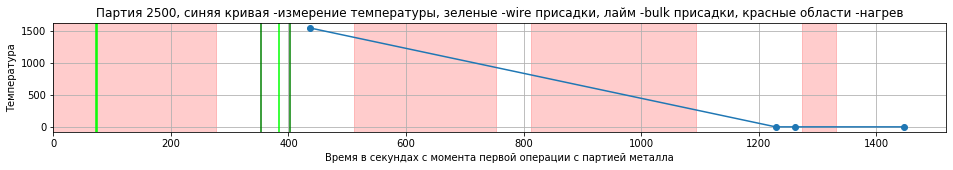

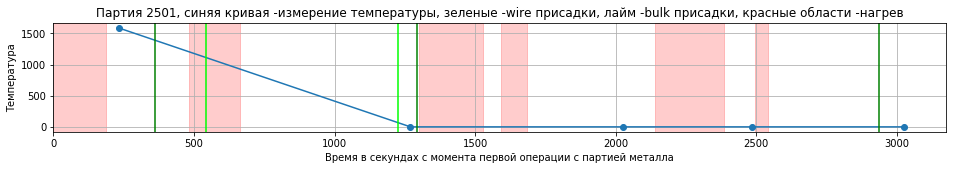

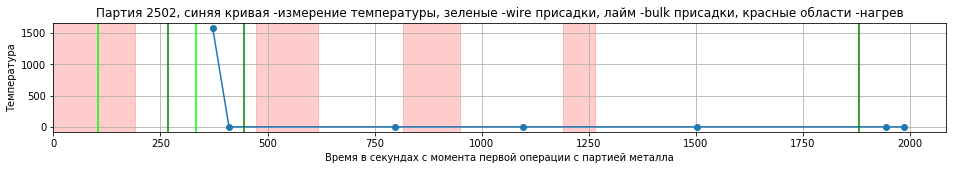

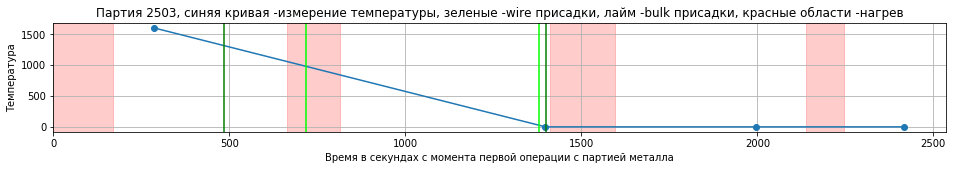

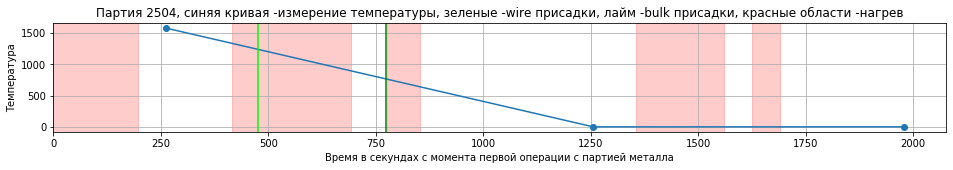

In [13]:
for key in data_temp_missed.head(5).index:
    show_process(key)

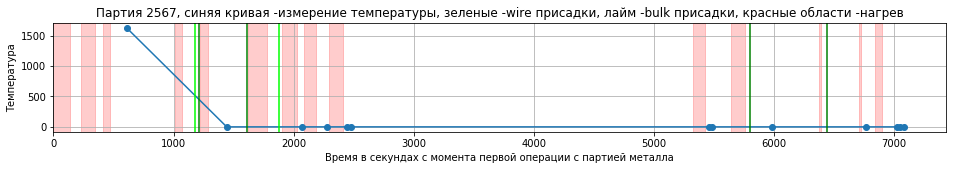

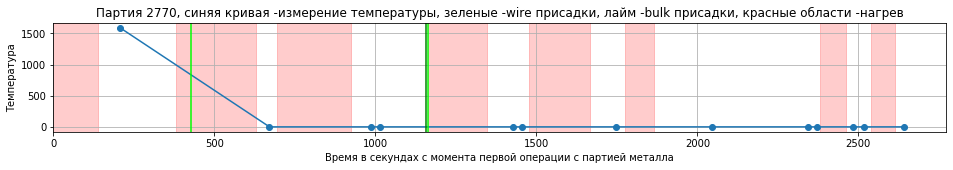

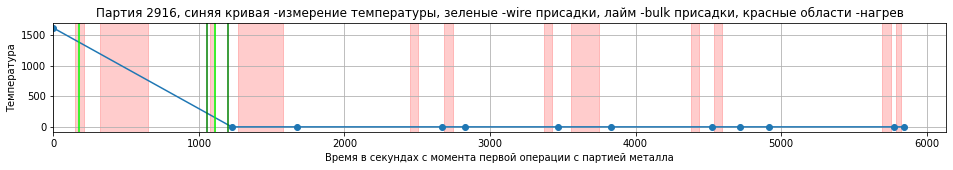

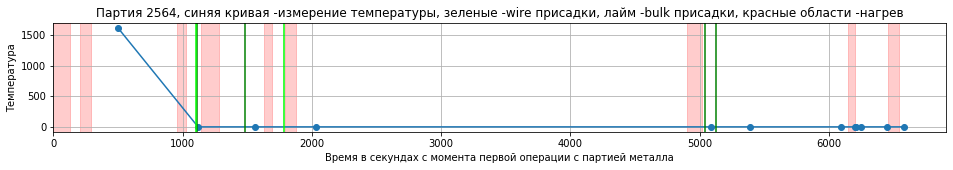

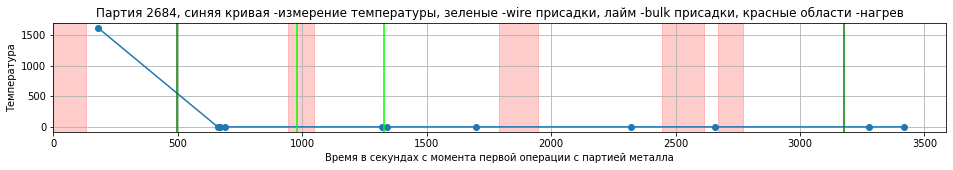

In [14]:
# теперь посмотрим на диаграммы партий с самым большим кол-вом неудачных измерений
for key in data_temp_missed.sort_values(by='Температура_все', ascending=False).head(5).index:
    show_process(key)

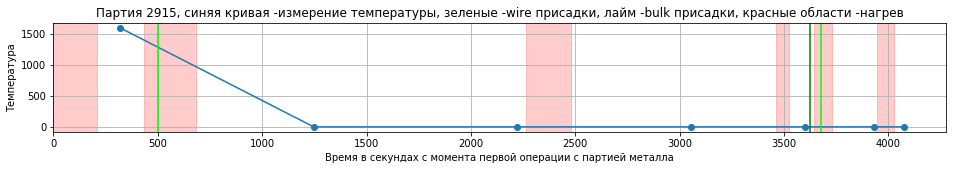

In [15]:
# есть аномальное измеренное значение в партии 2916, посмотрим на временную диаграмму партии 2915
show_process(2915)

Как уже говорилось, в каждой партии, где есть пропуски в измерениях температуры, есть одно и только одно корректное измерение. Судя по временным диаграммам случайно выбранных партий с пропусками в измерениях, единственно верное измерение является первым измерением в партии. Судя по графикам, в выбранных нами произвольно партиях это значение чуть более 1500. Хотя предположение, что температура в этих измерениях примерно одна и та же, может быть ошибкой и связано это просто с большим диапазоном шкалы температур на графиках для партий металла с пропусками в измерениях - мы присвоили пропускам 0, поэтому диапазон температур для этих графиков от 0 до более 1500, в отличие от нормального диапазона шкалы температур от 1500 до 1600. Тем не менее, убедимся, что особенностей нет. 

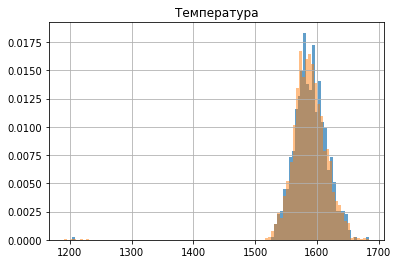

In [16]:
# выведем гистограмму распределения измеренной температуры для партий с пропусками температур
ax = data['temp'][data['temp']['key'].isin(data_temp_missed.index.tolist())].dropna().hist('Температура', bins=100, density=True, alpha=0.7)
# на эти же оси выведем гистограмму распределения первой измеренной температуры для всех партий
ax = data['temp'].groupby('key').agg({'Температура': 'first'}).hist('Температура', bins=100, ax=ax, density=True, alpha=0.5)

Гистограммы практически одинаковы. Значимых различий не наблюдается.

####  2.3. Выводы после изучения пропусков в измерениях температуры.
- В каждой партии, где есть пропуски в измерениях температуры, есть одно и только одно корректное измерение. Судя по всему, это единственное корректное значение является первым измерением температуры в партии.
- Я не вижу причин как-то особенно выделять корректные измерения температуры в тех партиях металла, где есть пропуски во всех других измерениях. При формировании данных для построения модели надо будет просто удалить данные с пропусками в значениях измеренной температуры, для других измерений температуры в этих же партиях сформировать признаки по той же методике, что и для всех других измерений температуры. Такую методику еще предстоит выработать.
- Было обнаружено аномальное измерение температуры в партии 2916 - по нашим данным не было ни нагрева, ни легирования этой партии до измерения температуры. При любой методике формирования признаков для обучения модели для этого объекта значения всех признаков будут равны 0. Возможно, это просто ошибочное измерение температуры. В пользу этого говорит также тот факт, что предыдущая обработанная партия металла также имела пропуски в измерениях температуры, причем эти пропуски предшествовали измеренному значению. С другой стороны, возможно, это значение задает нам точку отсчета  температур для всех других объектов. Вернемся к этому вопросу в дальнейшем после формирования всех признаков модели.

#### 2.4. Исследование данных обдува инертным газом.

На этапе ознакомления с данными я обратил внимание на отсутствие данных о времени обдува. Если исходить из предоставленного нам описания технологического процесса, обдув производится в моменты добавления легирующих присадок. В таком случае можно выдвинуть две гипотезы:
- После каждой операции добавления присадок производится обдув определенным, примерно одним и тем же, количеством инертного газа. 
- После каждой операции добавления присадок производится обдув инертным газом, причем кол-во используемого газа пропорционально общему добавленных кол-ву присадок. 

Проверим эти гипотезы. Сравним корреляцию между кол-вом инертного газа и кол-вом операций либо общей массой присадок. 

Для составления сводной таблицы по количеству операций легирования можно было бы просто определить пропуски методом .isna в каждом интересующем нас столбце, инвертировать ~, затем просуммировать по каждой строке True. Но ранее мы определили что некоторые присадки добавляются в одно и то же время и, значит, представляют из себя одну операцию легирования. Для подсчета уникальных операций легирования для каждой партии придется сделать чуть более сложную функцию обработки каждой строки. 

In [17]:
# функция обработки строки для таблиц wire_time или bulk_time
# в строке удаляется key (остаются только столбцы wire 1... wire N или bulk 1... bulk N), 
# затем удаляются все пропуски, затем удаляются все дубликаты (нам нужно учитывать только уникальные операции легирования)
def calc_operations(row):
    return len(row.drop('key').dropna().drop_duplicates())

# аналогичная функция суммирования всех добавок
def calc_suppl_mass(row):
    return row.drop('key').dropna().sum()

In [18]:
# создадим новую таблицу data_gas_and_supplement куда соберем данные по кол-ву инертного газа, по кол-ву операций и по общей массе легирования
data_gas_and_supplement = data['gas'].copy()

# для добавления новых столбцов к data_gas_and_supplement напишем функцию
def supple_info_add(supple_type): # supple_type принимает значения либо wire, либо bulk
    supple_operations = data[f'{supple_type}_time'].copy()
    supple_operations[f'{supple_type}_operations'] = supple_operations.apply(calc_operations, axis=1)
    supple_mass = data[supple_type].copy()
    supple_mass[f'{supple_type}_mass'] = supple_mass.apply(calc_suppl_mass, axis=1)
    return supple_operations.merge(supple_mass, on='key')[['key', f'{supple_type}_operations', f'{supple_type}_mass']]

In [19]:
# добавим в data_gas_and_supplement кол-во операций и общую массу присадок
for type_supple in ['wire', 'bulk']:
    data_gas_and_supplement = data_gas_and_supplement.merge(supple_info_add(type_supple), on='key', how='left')

In [20]:
data_gas_and_supplement

key      Газ 1  wire_operations   wire_mass  bulk_operations  bulk_mass
0        1  29.749986              1.0   60.059998              2.0      553.0
1        2  12.555561              1.0   96.052315              2.0      582.0
2        3  28.554793              1.0   91.160157              2.0      544.0
3        4  18.841219              1.0   89.063515              2.0      595.0
4        5   5.413692              2.0   98.352796              2.0      584.0
...    ...        ...              ...         ...              ...        ...
3234  3237   5.543905              1.0   38.088959              2.0      758.0
3235  3238   6.745669              1.0   56.128799              2.0      594.0
3236  3239  16.023518              1.0  143.357761              3.0      630.0
3237  3240  11.863103              1.0   34.070400              2.0      272.0
3238  3241  12.680959              1.0   63.117595              1.0      232.0

[3239 rows x 6 columns]

In [21]:
# заполним пропуски 0
data_gas_and_supplement = data_gas_and_supplement.fillna(0)

# и просуммируем кол-во операций и массу присадок
for suff in ['operations', 'mass']:
    data_gas_and_supplement[f'total_{suff}'] = data_gas_and_supplement[f'wire_{suff}'] + data_gas_and_supplement[f'bulk_{suff}']

In [22]:
# для визуализации зависимости общего кол-ва газа и других столбцов создадим функцию
def show_corr(col):
    corr = data_gas_and_supplement['Газ 1'].corr(data_gas_and_supplement[col])
    ax = data_gas_and_supplement.plot(x='Газ 1', y=col, kind='scatter', 
                                      figsize=(8, 4), grid=True, title=f'Линейная корреляция {corr:.3f}')

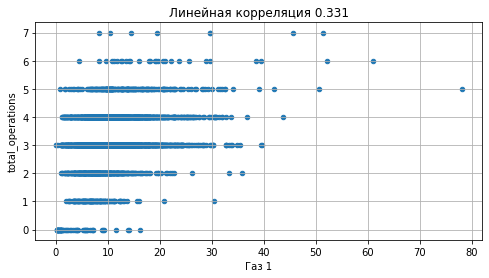

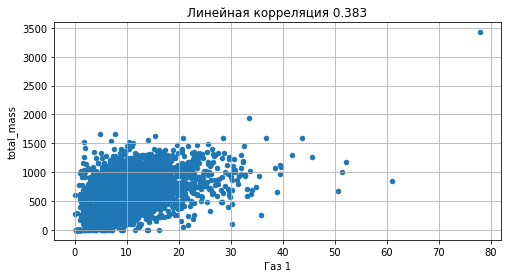

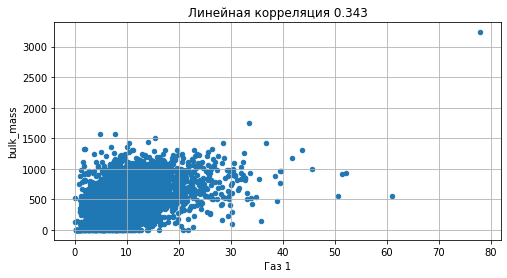

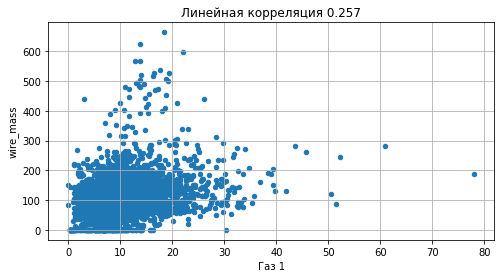

In [23]:
for col in ['total_operations', 'total_mass', 'bulk_mass', 'wire_mass']:
    show_corr(col)

#### 2.4. Выводы после исследование данных обдува инертным газом.
- Нам не было преодставлено данных о времени обдува партии металла инертным газом.
- Исходя из предоставленного нам описания технологического процесса (обдув производится в моменты добавления легирующих присадок), была исследована корреляция между массой газа для каждой партии и агрегированными данными по операциям легирования в этой же партии. 
- Наибольшая корреляция наблюдается между между массой газа и общей массой всех присадок.
- Я считаю самым целесообразным при формировании признака обучения модели, основанного на данных обдува, для времени обдува использовать время уникальной операции добавления присадок, а массу использованного для обдува газа в конкретной операции обдува посчитать по формуле:
$$
M_{key}^{i}(gas) = M_{key}^{total}(gas) * \frac{M_{key}^i(supplement)} {M_{key}^{total}(supplement)} 
$$

#### 2.5.  Исследование данных об активной и реактивной мощности.
С точки зрения физики на нагрев должна влиять только активная мощность. Реактивная мощность должна сильно коррелировать с активной мощностью, если не меняется конфигурация сети, влияющая на емкость, индуктивность, что в свою очередь влияет на сдвиг фазы между силой токой и нарпяжением и уже это влияет на соотношение между активной и реактивной мощностью. В любом случае кол-во тепла, а, значит, и изменение температуры, определяет только лишь активная мощность электричества. Тем не менее, изучим наборы данных по активной и реактивной мощности более внимательно.

In [24]:
def show_corr_power(df):
    corr = df['Активная мощность'].corr(df['Реактивная мощность'])
    ax = df[['Активная мощность', 'Реактивная мощность']].plot(
        x='Активная мощность', y='Реактивная мощность', kind='scatter', 
        figsize=(8, 4), grid=True, title=f'Линейная корреляция {corr:.3f}' )

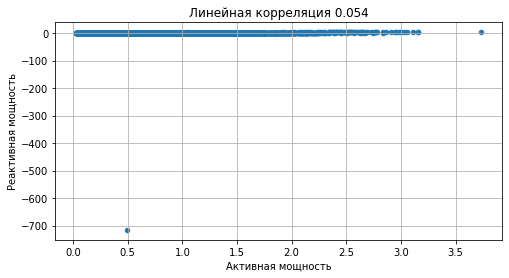

In [25]:
show_corr_power(data['arc'])

Увидеть корреляцию нельзя из-за единственного выброса с очень большим и отрицательным значением реактивной мощности. Посмотрим на диаграмму рассеяния без этого выброса

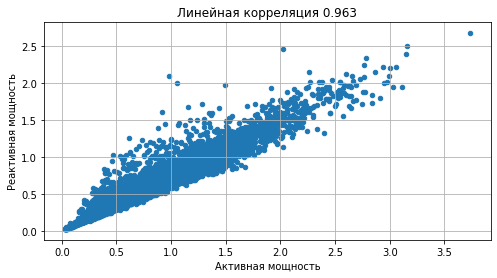

In [26]:
data_arc = data['arc'][data['arc']['Реактивная мощность'] >= 0 ]
show_corr_power(data_arc)

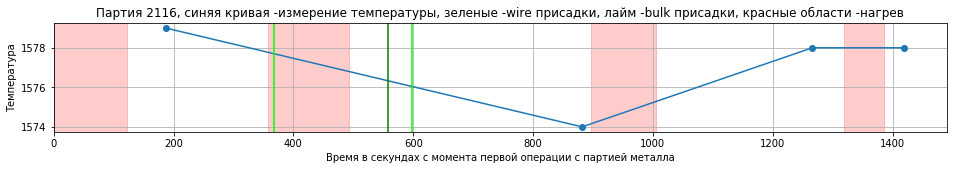

In [27]:
# посмотрим еще на временную диаграмму процесса для партий металла с аномальным значением реактивной мощности
for key in data['arc'][data['arc']['Реактивная мощность'] < 0]['key']:
    show_process(key)

#### 2.5.  Выводы после исследования данных об активной и реактивной мощности.
- Был подтвержден тезис, основанный на знаниях физики, что реактивная мощность линейно связана с активной мощностью.
- Итак, во-первых, опираясь на знание физики, можно утверждать, что реактивная мощность не влияет на передачу тепла расплаву. Во-вторых, исследование корреляции между реактивной  и активной мощностью продемонстрировало очень сильную линейную зависимость между ними (с точки зрения физики это означает, что в нашей конфигурации электрической сети мало меняются индуктивность и емкость). 
- Я считаю целесообразным никак не использовать признак "реактивная мощность" для нашей модели.

## 2. План дальнейших действий (выводы после исследовательского анализа данных )
- Наш целевой признак - температура. Все пропуски температуры надо удалить. Соответственно, общее кол-во объектов для обучения и тестирования модели составит не более 13006 объектов (возможно, некоторые объекты с корректной температурой будут признаны негодными из-за отсутствия обучающих признаков, как в единственном корректном измерении температуры для партии 2916).
- Все обучающие признаки для модели будут извлекаться из других таблиц по уникальному номеру партии металла (key):
 1. Heating: выбираем все операции нагрева для того же key, произошедшие до измерения температуры, умножаем длительность каждой операции нагрева в секундах на активную мощность, суммируем полученные значения, при этом учитываем краевой эффект - последняя операция нагрева перед измерением могла не закончиться, хотя мы и не встречали такого случая при визуализации процессов.  
 - Cooldown: считаем временной промежуток в секундах между временем измерения температуры и стартом процесса обработки металла  = min от всех временных значений для данного key.
 - Blow_on: выбираем все операции обдува для того же key, произошедшие до измерения температуры, суммируем массы инертного газа для всех совершенных операций обдува, массу для каждой операции рассчитываем по формуле:
$$
M_{key}^{i}(gas) = M_{key}^{total}(gas) * \frac{M_{key}^i(supplement)} {M_{key}^{total}(supplement)} 
$$
 - Supplement_wire: выбираем все операции добавления присадок в виде проволоки для того же key, произошедшие до измерения температуры, суммируем массы присадок.
 - Supplement_bulk: аналогично для присадок bulk. Считаю целесообразным разделить присадки по типу, поскольку возможно разное влияние на температуру в зависимости от состояния вещества.

## 3. Подготовка данных для модели - формирование признаков и цели.

После уточнения задачи тимлидом стало понятно, что нам надо предсказывать последнее измерение температуры в партии. При этом мы можем использовать первое измерение температуры в партии в качестве фичи. В процессе исследования данных было продемонстрировано, что первое и последнее измерение температур не являются нижней и верхней границей для всех операций обработки партии металла - есть много партий металла, например, когда некоторые операции нагрева и/или легирования осуществлялись до первого измерения. Это надо будет учесть при извлечении из данных признаков для нашего моделирования.

#### 3.1. Извлечение последнего (target) и первого (feature) измерения температуры.

In [28]:
# сформируем таблицу, куда внесем первое и последнее измеренное значение температуры и время этих измерений для каждого key
data_temp = data['temp'].dropna()
temp_key = data_temp.sort_values(by='Время замера').groupby('key').agg({
    'Время замера':['first','last'], 
    'Температура':['first','last']})
temp_key.columns = ['first_temp_measure', 'last_temp_measure', 'first_temp','last_temp']
temp_key = temp_key[temp_key.first_temp_measure != temp_key.last_temp_measure]

In [29]:
temp_key.head()

first_temp_measure   last_temp_measure  first_temp  last_temp
key                                                               
1   2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0     1613.0
2   2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0     1602.0
3   2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0     1599.0
4   2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0     1625.0
5   2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0     1602.0

In [30]:
temp_key.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_temp_measure  2475 non-null   datetime64[ns]
 1   last_temp_measure   2475 non-null   datetime64[ns]
 2   first_temp          2475 non-null   float64       
 3   last_temp           2475 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.7 KB


In [31]:
# убедимся, что значения во времени корректные
(temp_key['last_temp_measure'] <= temp_key['first_temp_measure']).sum()

0

#### 3.2. Извлечение операций нагрева, произошедших между первым и последним измереним температур.
- Очевидно, что те нагревы, которые были до первого измерения температуры, "включены" в первое измерение и в нашей будущей модели не могут быть признаками. То же самое можно сказать и о нагревах, произошедших после последнего измерения. 
- Возможно, в некоторых партиях одно из измерений температуры происходило в момент нагрева, это также необходимо учесть.

In [32]:
# сначала сформируем таблицу, куда для каждой операции нагрева добавим время первого и последнего измерения температуры
heat_sessions = data['arc'].copy()
heat_sessions = heat_sessions.join(temp_key, on='key')

In [33]:
# убедимся, что значения во времени операций нагрева корректные
(heat_sessions['Начало нагрева дугой'] >= heat_sessions['Конец нагрева дугой']).sum()

0

In [34]:
# теперь для каждой операции нагрева посчитаем кол-во переданного тепла, но будем учитывать пересечение 
# временных интервалов нагрева и интервала между первым и последним измерением температур
heat_sessions['new_start'] = heat_sessions[['Начало нагрева дугой', 'first_temp_measure']].max(axis=1)
heat_sessions['new_finish'] = heat_sessions[['Конец нагрева дугой', 'last_temp_measure']].min(axis=1)
heat_sessions['new_finish'] = heat_sessions['new_finish'].where(heat_sessions['new_finish'] > heat_sessions['new_start'], heat_sessions['new_start'])
heat_sessions['get_warmth'] = (heat_sessions['new_finish'] - heat_sessions['new_start']).dt.seconds * heat_sessions['Активная мощность']

In [35]:
# теперь агрегируем данные нагрева для каждого key
heat_key = heat_sessions.groupby('key').agg({
    'Начало нагрева дугой' : 'min',
    'Конец нагрева дугой' : 'max',
    'get_warmth' : 'sum'})
heat_key.columns = ['first_heat_start', 'last_heat_end', 'get_warmth']

In [36]:
heat_key.head()

first_heat_start       last_heat_end  get_warmth
key                                                    
1   2019-05-03 11:02:14 2019-05-03 11:28:37  708.195035
2   2019-05-03 11:34:14 2019-05-03 11:53:18  673.801792
3   2019-05-03 12:06:54 2019-05-03 12:32:19  146.208505
4   2019-05-03 12:39:37 2019-05-03 12:57:50  339.425494
5   2019-05-03 13:11:13 2019-05-03 13:33:55  691.980241

####  3.3. Извлечение данных о легировании.
По аналогии с нагревом будем агрегировать данные по легированию, включая в признаки будущей модели данные только для тех операций легирования, которые происходили между первым и последним измерением температуры.

In [37]:
# создадим функцию, которая возвращает новый df, содержащий массы только тех добавок,
# которые были внесены в партию металла в период времени между первым измерением температуры и последним 
def supple_intime(type_supple):
    data_supple = data[type_supple].copy().set_index('key').fillna(0) # заполним нулями пропуски в таблице масс различных присадок
    col_of_supple = data_supple.columns.to_list() # сформируем список столбцов присадок (bulk 1, bulk 2.... или wire 1, wire 2, ...)
    data_supple_times = data[f'{type_supple}_time'].copy().set_index('key') 
    data_supple_times = data_supple_times.join(temp_key) # присоединим таблицу, где есть столбцы с первым измерением температуры и последним
    for col in col_of_supple: # теперь столбцы с временем легирования заменим на булевые значения (True для тех присадок, которые между первым и последним)
        data_supple_times[col] = (data_supple_times[col] >= data_supple_times['first_temp_measure']) & (data_supple_times[col] <= data_supple_times['last_temp_measure'])
        # data_supple_times[col] = (data_supple_times[col] <= data_supple_times['last_temp_measure'])
    data_supple_times = data_supple_times[col_of_supple] # оставим только булевые столбцы
    return data_supple * data_supple_times 

In [38]:
bulk_key = supple_intime('bulk')
bulk_key.head()

Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

     Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
key                                                        
1        0.0      0.0      0.0      0.0      0.0      0.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0      0.0      0.0      0.0      0.0  
4        0.0      0.0      0.0      0.0      0.0      0.0  
5        0.0      0.0      0.0      0.0      0.0      0.0

In [39]:
wire_key = supple_intime('wire')
wire_key.head()

Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                       
1     0.000000  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.000000  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.000000  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     Wire 9  
key          
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0

#### 3.4. Расчет кол-ва газа, использованного для обдува
Нам не были предоставлены данные по времени обдува. На этапе исследования данных мы установили наиболее вероятную формулу расчета массы газа, использованного для обдува в каждой операции легирования. Используем данную формулу, а именно:
$$
M_{key}^{i}(gas) = M_{key}^{total}(gas) * \frac{M_{key}^i(supplement)} {M_{key}^{total}(supplement)} 
$$

при расчете кол-ва газа, использованного для обдува, который производился в период между первым и последним измерением температур.

In [40]:
def calc_total(df_supple):
    total_supple = pd.Series(0, index=df_supple.index)
    for col in df_supple.columns:
        total_supple += df_supple[col]
    return total_supple

In [41]:
bulk_key['bulk_intime'] = calc_total(bulk_key)
bulk_key['bulk_total'] = calc_total(data['bulk'].set_index('key').fillna(0))
bulk_key.head()

Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

     Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  bulk_intime  \
key                                                                      
1        0.0      0.0      0.0      0.0      0.0      0.0         43.0   
2        0.0      0.0    206.0      0.0    149.0    154.0        582.0   
3        0.0      0.0      0.0      0.0      0.0      0.0         34.0   
4        0.0      0.0      0.0      0.0      0.0      0.0          0.0   
5        0.0      0.0      0.0      0.0      0.0      0.0          0.0   

     bulk_total  
key              
1         553.0  
2         582.0  
3         544.0  
4         595.0  
5         584.0

In [42]:
wire_key['wire_intime'] = calc_total(wire_key)
wire_key['wire_total'] = calc_total(data['wire'].set_index('key').fillna(0))
wire_key.head()

Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                       
1     0.000000  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.000000  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.000000  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     Wire 9  wire_intime  wire_total  
key                                   
1       0.0     0.000000   60.059998  
2       0.0    96.052315   96.052315  
3       0.0    91.160157   91.160157  
4       0.0     0.000000   89.063515  
5       0.0     9.114560   98.352796

In [43]:
supplements_total = bulk_key.join(wire_key, how='outer')
supplements_total = supplements_total.fillna(0)
supplements_total['ratio'] = ((supplements_total['bulk_intime'] + supplements_total['wire_intime']) /
                             (supplements_total['bulk_total'] + supplements_total['wire_total']))                                                   

In [44]:
# присоединим данные по обдуву 
gas_key = data['gas'].set_index('key')
gas_key.columns = ['total_gas']
supple_and_gas = supplements_total.join(gas_key, how='outer')
supple_and_gas = supple_and_gas.fillna(0)
supple_and_gas['total_gas'] = supple_and_gas['total_gas'] * supple_and_gas['ratio']

#### 3.5. Объединение данных по разным операциям.

In [45]:
# объединим все таблицы
data_key = temp_key.join([heat_key, supple_and_gas])

In [46]:
data_key_ready = data_key.copy()
# добавим столбец с длительностью в секундах между самой первой операцией над партией металла и временем измерения температуры
data_key_ready['duration_process'] = (data_key_ready['last_temp_measure'] - data_key_ready['first_temp_measure']).dt.seconds
data_key_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_temp_measure  2475 non-null   datetime64[ns]
 1   last_temp_measure   2475 non-null   datetime64[ns]
 2   first_temp          2475 non-null   float64       
 3   last_temp           2475 non-null   float64       
 4   first_heat_start    2475 non-null   datetime64[ns]
 5   last_heat_end       2475 non-null   datetime64[ns]
 6   get_warmth          2475 non-null   float64       
 7   Bulk 1              2475 non-null   float64       
 8   Bulk 2              2475 non-null   float64       
 9   Bulk 3              2475 non-null   float64       
 10  Bulk 4              2475 non-null   float64       
 11  Bulk 5              2475 non-null   float64       
 12  Bulk 6              2475 non-null   float64       
 13  Bulk 7              2475 non-null   float64     

In [47]:
def supple_cols(supple_type):
    cols_to_keep = data[supple_type].columns.to_list()
    cols_to_keep.remove('key')
    return cols_to_keep

In [48]:
# сформируем целевой признак и обучающие признаки
y = data_key_ready['last_temp']
features_cols = ['first_temp', 'get_warmth', 'total_gas', 'duration_process', *supple_cols('bulk'), *supple_cols('wire')]
X = data_key_ready[features_cols]
# X = data_key_ready.drop(cols_to_drop, axis=1)

In [49]:
X.head()

first_temp  get_warmth  total_gas  duration_process  Bulk 1  Bulk 2  \
key                                                                        
1        1571.0  708.195035   2.086663               861     0.0     0.0   
2        1581.0  673.801792  12.555561              1305     0.0     0.0   
3        1596.0  146.208505   5.626805              1300     0.0     0.0   
4        1601.0  339.425494   0.000000               388     0.0     0.0   
5        1576.0  691.980241   0.072314               762     0.0     0.0   

     Bulk 3  Bulk 4  Bulk 5  Bulk 6  ...  Bulk 15     Wire 1   Wire 2  Wire 3  \
key                                  ...                                        
1       0.0    43.0     0.0     0.0  ...      0.0   0.000000  0.00000     0.0   
2       0.0    73.0     0.0     0.0  ...    154.0  96.052315  0.00000     0.0   
3       0.0    34.0     0.0     0.0  ...      0.0  91.160157  0.00000     0.0   
4       0.0     0.0     0.0     0.0  ...      0.0   0.000000  0.00000     0.0   
5       0.0     0.0     0.0     0.0  ...      0.0   0.000000  9.11456     0.0   

     Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
key                                                  
1       0.0     0.0     0.0     0.0     0.0     0.0  
2       0.0     0.0     0.0     0.0     0.0     0.0  
3       0.0     0.0     0.0     0.0     0.0     0.0  
4       0.0     0.0     0.0     0.0     0.0     0.0  
5       0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 28 columns]

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   first_temp        2475 non-null   float64
 1   get_warmth        2475 non-null   float64
 2   total_gas         2475 non-null   float64
 3   duration_process  2475 non-null   int64  
 4   Bulk 1            2475 non-null   float64
 5   Bulk 2            2475 non-null   float64
 6   Bulk 3            2475 non-null   float64
 7   Bulk 4            2475 non-null   float64
 8   Bulk 5            2475 non-null   float64
 9   Bulk 6            2475 non-null   float64
 10  Bulk 7            2475 non-null   float64
 11  Bulk 8            2475 non-null   float64
 12  Bulk 9            2475 non-null   float64
 13  Bulk 10           2475 non-null   float64
 14  Bulk 11           2475 non-null   float64
 15  Bulk 12           2475 non-null   float64
 16  Bulk 13           2475 non-null   float64


## 4. Обучение и выбор модели.

In [51]:
X_train = {}
X_test = {}
RANDOM_STATE = 1234
X_train['raw'], X_test['raw'], y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
# для сравнения разных моделей создадим df с результатами метрик
results = pd.DataFrame(columns=['MAE on test data', 'MAE on train data', 'MAE_test / MAE_train'])
# и с показателями feature_importances_
fi = pd.DataFrame(index=X.columns)

In [52]:
# стандартизуем данные
scaler = StandardScaler()
scaler.fit(X_train['raw']) 
X_train['standart'] = scaler.transform(X_train['raw'])
X_test['standart'] = scaler.transform(X_test['raw'])

In [53]:
# функция добавляет результаты в итоговую таблицу для уже обученной модели
def add_results(model, model_name, data_type):
    y_test_predict = model.predict(X_test[data_type])
    mae_test = mean_absolute_error(y_test, y_test_predict)
    y_train_predict = model.predict(X_train[data_type])
    mae_train = mean_absolute_error(y_train, y_train_predict)
    results.loc[model_name, 'MAE on test data'] = mae_test
    results.loc[model_name, 'MAE on train data'] = mae_train
    results.loc[model_name, 'MAE_test / MAE_train'] = mae_test / mae_train


In [54]:
class DummyModel:
    def fit(self, y_train):
        self.meaning = y_train.median()
    def predict(self, X):
        dummy_predict = np.full(X.shape[0], self.meaning)
        return dummy_predict

In [55]:
dummy = DummyModel()
dummy.fit(y_train)
add_results(dummy, 'Dummy model, median value in train data', 'raw')

#### Линейная регрессия.

In [56]:
model = LinearRegression().fit(X_train['standart'], y_train)
add_results(model, 'Linear regression, default parameters, standart data', 'standart')

In [57]:
results

MAE on test data  \
Dummy model, median value in train data                     10.0872   
Linear regression, default parameters, standart...          7.71973   

                                                   MAE on train data  \
Dummy model, median value in train data                       9.8319   
Linear regression, default parameters, standart...           7.50882   

                                                   MAE_test / MAE_train  
Dummy model, median value in train data                         1.02597  
Linear regression, default parameters, standart...              1.02809

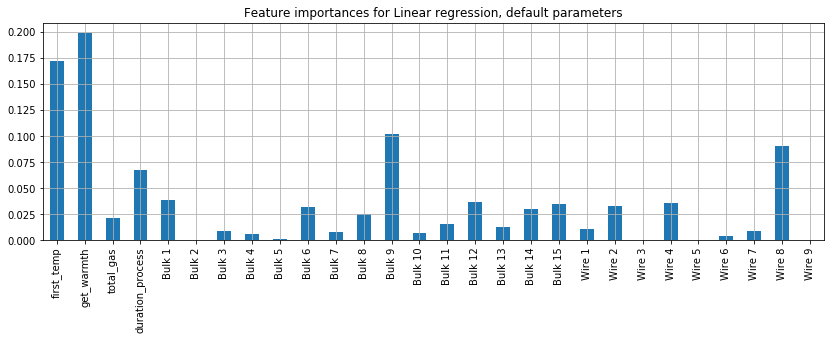

In [58]:
# добавим данные в таблицу fi
feature_importances = pd.Series(model.coef_, index=X.columns)
feature_importances = feature_importances.abs()
feature_importances = feature_importances / feature_importances.sum()
ax = feature_importances.plot(kind='bar', grid=True, figsize=(14,4), title='Feature importances for Linear regression, default parameters')
fi['LR'] = feature_importances

#### Случайный лес.

In [59]:
# функция выбирает лучшие гиперпараметры модели кросс-валидацией, 
# затем обучает модель с этими параметрами на всем train наборе, затем добавляет результат в итоговую таблицу
def select_model(model_method, param_grid, data_type):
    model = model_method(random_state=RANDOM_STATE)
    CV_model = GridSearchCV(estimator=model, param_grid=param_grid, error_score='neg_mean_absolute_error', cv=5)
    CV_model.fit(X_train[data_type], y_train)
    model_best = model_method(random_state=RANDOM_STATE, **CV_model.best_params_)
    model_best.fit(X_train[data_type], y_train)
    param_summary = ''
    for param in CV_model.best_params_:
        param_summary += str(param) + '='
        param_summary += str(CV_model.best_params_[param]) + ' '
    model_best_name = f'{model_best.__class__.__name__}, {param_summary}, {data_type} data'
    add_results(model_best, model_best_name, data_type)
    feature_importances = pd.Series(model_best.feature_importances_, index=X.columns)
    model_best_summary = model_best_name + ': '
    for col in results.columns:
        model_best_summary += col + ': ' + str(round(results.loc[model_best_name, col], 1)) + ' '
    ax = feature_importances.plot(kind='bar', grid=True, title = model_best_summary, figsize=(14,4))
    return feature_importances

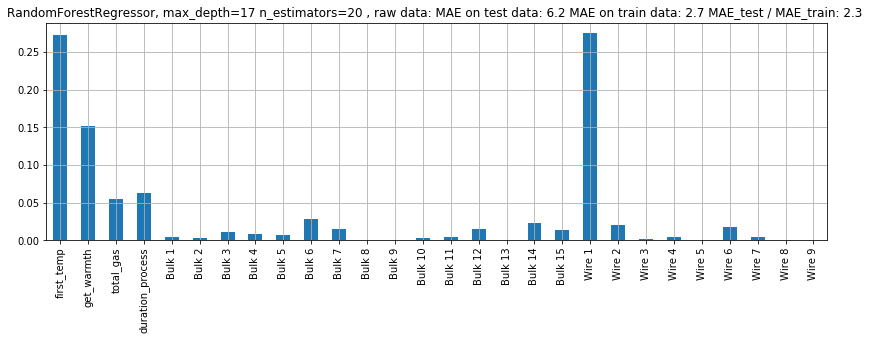

In [60]:
# не будем производить поиск с кросс-валидацией по всей матрице (глубина, кол-во деревьев), 
# определим сначала лучшую глубину на небольшом кол-ве деревьев
fi_new = select_model(RandomForestRegressor, {'max_depth' : range(5, 20), 'n_estimators' : [20]}, 'raw')

In [61]:
fi['RF_d17_est20'] = fi_new

In [62]:
results

MAE on test data  \
Dummy model, median value in train data                     10.0872   
Linear regression, default parameters, standart...          7.71973   
RandomForestRegressor, max_depth=17 n_estimator...          6.20103   

                                                   MAE on train data  \
Dummy model, median value in train data                       9.8319   
Linear regression, default parameters, standart...           7.50882   
RandomForestRegressor, max_depth=17 n_estimator...           2.68328   

                                                   MAE_test / MAE_train  
Dummy model, median value in train data                         1.02597  
Linear regression, default parameters, standart...              1.02809  
RandomForestRegressor, max_depth=17 n_estimator...              2.31099

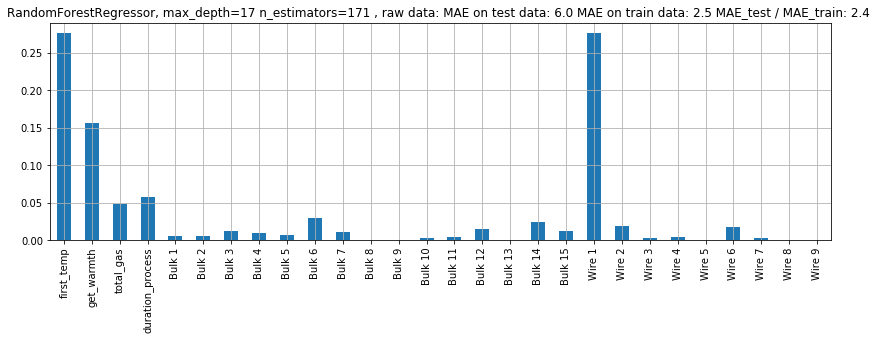

In [63]:
# теперь подберем лучшее кол-во оценщиков
fi_new = select_model(RandomForestRegressor, {'max_depth' : [17], 'n_estimators' : range(90, 180, 9)}, 'raw')

In [64]:
fi['RF_d17_est171'] = fi_new

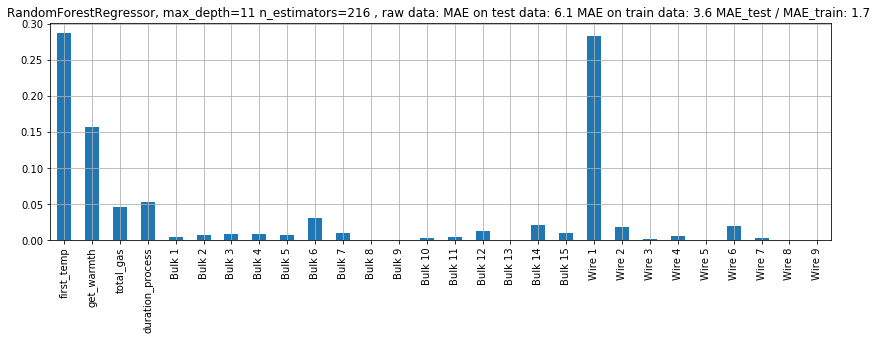

In [65]:
# лес сильно переобучен, попробуем сильнее ограничить число уровней
fi_new = select_model(RandomForestRegressor, {'max_depth' : [11], 'n_estimators' : range(171, 220, 9)}, 'raw')

In [66]:
fi['RF_d11_est216'] = fi_new

In [67]:
results

MAE on test data  \
Dummy model, median value in train data                     10.0872   
Linear regression, default parameters, standart...          7.71973   
RandomForestRegressor, max_depth=17 n_estimator...          6.20103   
RandomForestRegressor, max_depth=17 n_estimator...          6.04314   
RandomForestRegressor, max_depth=11 n_estimator...          6.11885   

                                                   MAE on train data  \
Dummy model, median value in train data                       9.8319   
Linear regression, default parameters, standart...           7.50882   
RandomForestRegressor, max_depth=17 n_estimator...           2.68328   
RandomForestRegressor, max_depth=17 n_estimator...           2.51325   
RandomForestRegressor, max_depth=11 n_estimator...           3.61589   

                                                   MAE_test / MAE_train  
Dummy model, median value in train data                         1.02597  
Linear regression, default parameters, standart...              1.02809  
RandomForestRegressor, max_depth=17 n_estimator...              2.31099  
RandomForestRegressor, max_depth=17 n_estimator...              2.40451  
RandomForestRegressor, max_depth=11 n_estimator...              1.69221

### Градиентный бустинг.

Библиотека LightGBM позволяет проводить обучение на train наборе, останавливая обучение, если целевая метрика на validation наборе перестает улучшаться. Для того, чтобы "не заглядывать в будущее", я поступлю следующим образом - разобью исходный набор данных на train и valid с другим random_state. На этом разбиении получу наилучший гиперпараметр  - кол-во деревьев. Затем, используя этот гиперпараметр, переобучу модель на стандартном train наборе для всех предыдущих моделей и полученную на test наборе метрику внесу в конечную таблицу.

In [68]:
RANDOM_STATE_LGB = RANDOM_STATE + 1
X_train_lgb, X_valid, y_train_lgb, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE_LGB)

In [69]:
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE_LGB)
model_lgb.fit(X_train_lgb, y_train_lgb, eval_set=[(X_valid, y_valid)], eval_metric='l1', early_stopping_rounds=5, verbose=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1235, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [70]:
n_estimators_lgb = model_lgb.best_iteration_

In [71]:
model_lgb_final = lgb.LGBMRegressor(random_state=RANDOM_STATE_LGB, n_estimators=n_estimators_lgb)
model_lgb_final.fit(X_train['raw'], y_train, verbose=0)
add_results(model_lgb_final, f'LightGBM, n_estimators={n_estimators_lgb}, raw data', 'raw')
results

MAE on test data  \
Dummy model, median value in train data                     10.0872   
Linear regression, default parameters, standart...          7.71973   
RandomForestRegressor, max_depth=17 n_estimator...          6.20103   
RandomForestRegressor, max_depth=17 n_estimator...          6.04314   
RandomForestRegressor, max_depth=11 n_estimator...          6.11885   
LightGBM, n_estimators=56, raw data                         5.86435   

                                                   MAE on train data  \
Dummy model, median value in train data                       9.8319   
Linear regression, default parameters, standart...           7.50882   
RandomForestRegressor, max_depth=17 n_estimator...           2.68328   
RandomForestRegressor, max_depth=17 n_estimator...           2.51325   
RandomForestRegressor, max_depth=11 n_estimator...           3.61589   
LightGBM, n_estimators=56, raw data                          3.86632   

                                                   MAE_test / MAE_train  
Dummy model, median value in train data                         1.02597  
Linear regression, default parameters, standart...              1.02809  
RandomForestRegressor, max_depth=17 n_estimator...              2.31099  
RandomForestRegressor, max_depth=17 n_estimator...              2.40451  
RandomForestRegressor, max_depth=11 n_estimator...              1.69221  
LightGBM, n_estimators=56, raw data                             1.51678

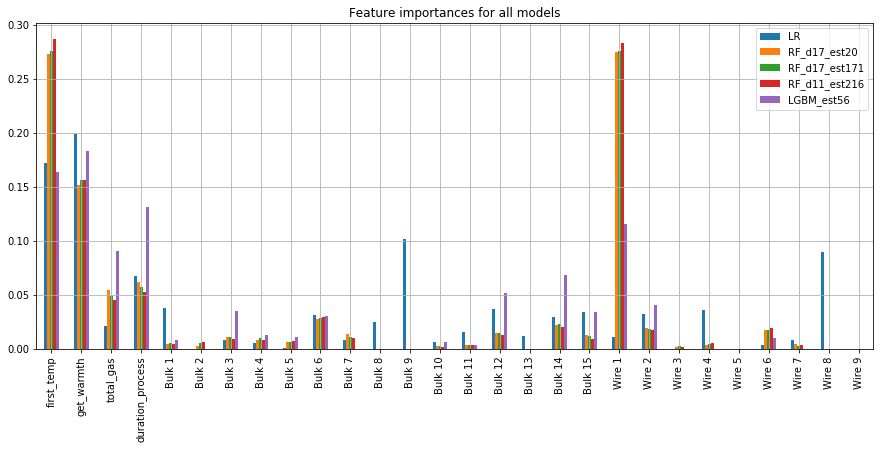

In [72]:
# добавим данные в таблицу fi
fi_new = pd.Series(model_lgb_final.feature_importances_, index=X.columns)
fi_new = fi_new / fi_new.sum()
fi['LGBM_est56'] = fi_new
ax = fi.plot(kind='bar', grid=True, figsize=(15,6), title='Feature importances for all models')

На общем графике хорошо видно, что первое измерение температуры, полученное тепло, кол-во газа для обдува и промежуток времени между измерениями температур являются неотъемлемыми признаками для любой модели. Данные по легированию для разных методов моделирования имеют различную важность. Тем не менее, можно выделить те добавки, которые также важны для любого метода моделирования - Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2, Wire 6. Попробуем улучшить качество лучшей модели, оставив для обучения только те признаки, которые имеют высокую важность.

In [73]:
cols_to_keep = fi[fi['LGBM_est56'] > 0].index.to_list()

In [74]:
X = X[cols_to_keep]
X_train_lgb, X_valid, y_train_lgb, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE_LGB)
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE_LGB)
model_lgb.fit(X_train_lgb, y_train_lgb, eval_set=[(X_valid, y_valid)], eval_metric='l1', early_stopping_rounds=5, verbose=0)
n_estimators_lgb = model_lgb.best_iteration_
model_lgb_final = lgb.LGBMRegressor(random_state=RANDOM_STATE_LGB, n_estimators=n_estimators_lgb)
model_lgb_final.fit(X_train['raw'], y_train, verbose=0)
add_results(model_lgb_final, f'LightGBM, drop non important features, n_estimators={n_estimators_lgb}, raw data', 'raw')
results

MAE on test data  \
Dummy model, median value in train data                     10.0872   
Linear regression, default parameters, standart...          7.71973   
RandomForestRegressor, max_depth=17 n_estimator...          6.20103   
RandomForestRegressor, max_depth=17 n_estimator...          6.04314   
RandomForestRegressor, max_depth=11 n_estimator...          6.11885   
LightGBM, n_estimators=56, raw data                         5.86435   
LightGBM, drop non important features, n_estima...          5.87007   

                                                   MAE on train data  \
Dummy model, median value in train data                       9.8319   
Linear regression, default parameters, standart...           7.50882   
RandomForestRegressor, max_depth=17 n_estimator...           2.68328   
RandomForestRegressor, max_depth=17 n_estimator...           2.51325   
RandomForestRegressor, max_depth=11 n_estimator...           3.61589   
LightGBM, n_estimators=56, raw data                          3.86632   
LightGBM, drop non important features, n_estima...           3.95438   

                                                   MAE_test / MAE_train  
Dummy model, median value in train data                         1.02597  
Linear regression, default parameters, standart...              1.02809  
RandomForestRegressor, max_depth=17 n_estimator...              2.31099  
RandomForestRegressor, max_depth=17 n_estimator...              2.40451  
RandomForestRegressor, max_depth=11 n_estimator...              1.69221  
LightGBM, n_estimators=56, raw data                             1.51678  
LightGBM, drop non important features, n_estima...              1.48445

## Выводы.
- Для формирования признаков модели использовались данные о нагреве, легировании и обдуве. Учитывались данные только для тех операций, которые производились в период времени между первым и последним (целевым) измерением температуры.
- Целевого значения метрики MAE на тестовом наборе удалось достигнуть  при моделировании методом градиентного бустинга,  MAE = 5.86. Ошибка почти в два раза лучше dummy прогнозирования. Близкий к этому результат получен и методом случайного леса (MAE=6.04), но при существенно бОльшем уровне переобученности модели.
- Были продемонстрированы наиболее важные признаки для разных моделей при прогнозировании целевого измерения температуры. Удаление неважных признаков позволило уменьшить степень переобученности лучшей модели. 
- Полученная модель и способ формирования признаков для нее позволяют прогнозировать не только конечную температуру партии, имея начальную, но и температуру, вообще говоря, в любой момент времени в процессе обработки партии, имея лишь  какое-то измерение температуры, произведенное ранее, и информацию обо всех операциях нагрева, легирования и обдува в промежутке времени между измерениями.
- С учетом сказанного выше, можно попытаться улучшить качество обучения модели, сформировав значительно бОльшее кол-во объектов для обучения. Для этого из данных по каждой партии металла (key) можно формировать не один, как у нас, а несколько наблюдений с разными парами t_temp_before, t_temp_after, главное, что между этими временами были операции, влияющие на изменение температуры. 

## Отчет.
1. Выполнены все пункты плана. Для формирования признаков модели использовались данные о нагреве, легировании и обдуве. Учитывались данные только для тех операций, которые производились в период времени между первым и последним (целевым) измерением температуры.
2. При выполнении работы была трудность с данными об обдуве газом - данные были только целиком по всей партии, без указания времени. Преодолел проблему следующим образом. Еще на этапе EDA проверил несколько гипотез - кол-во использованного газа для обдува связано с общим кол-вом операций легирования (то есть предположение, что обдув производится одинаковыми порциями за каждую операцию обдува), кол-во газа для обдува связано с массой тех присадок, которые были добавлены в партию в соотв. момент времени. В результате анализа выбрал вариант формулы расчета кол-ва газа для каждой операции обдува, который и использовал для формирования признаков (подробности описаны в соотв. разделах тетради).
3. Я считаю, что ключевым моментом моделирования был тщательный EDA, поскольку для всего моделирования самым сложным было формирование и извлечение признаков из предоставленных данных. 
4. Наилучшая модель показала MAE на тестовом наборе данных 5.86.

### Предложение по улучшению моделирования.
Полученная модель и способ формирования признаков для нее позволяют прогнозировать не только конечную температуру партии, имея начальную, но и температуру, вообще говоря, в любой момент времени в процессе обработки партии, имея лишь какое-то измерение температуры, произведенное ранее, и информацию обо всех операциях нагрева, легирования и обдува в промежутке времени между измерениями. Можно попытаться улучшить качество обучения модели, сформировав значительно бОльшее кол-во объектов для обучения. Для этого из данных по каждой партии металла (key) можно формировать не один, как у нас, а несколько наблюдений с разными парами t_temp_before, t_temp_after, главное, чтобы между этими временами были операции, влияющие на изменение температуры.